In [1]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_curve,auc
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# data preprocess tools
from nltk import data
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, RegexpTokenizer


In [2]:
import stanza
#stanza.download('en')
nlp = stanza.Pipeline(lang='en', processors='tokenize,ner')

2021-11-15 10:22:11 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| ner       | ontonotes |

2021-11-15 10:22:11 INFO: Use device: cpu
2021-11-15 10:22:11 INFO: Loading: tokenize
2021-11-15 10:22:11 INFO: Loading: ner
2021-11-15 10:22:11 INFO: Done loading processors!


In [138]:
data = pd.read_excel('./dataset.xlsx')
data

,content,label
0,@Ricardo70078700 I have a big problem buying f...,0
1,RT @tconnellyRTE : 6/ “One colleague working o...,0
2,RT @joncstone : In case you missed this from m...,0
3,RT @AlexandravonNah : EU climate chief: 'We ne...,0
4,RT @Fourens__ : My colleague just told me she ...,0
...,...,...
637,"My boss's dog married my dog, and he covered m...",0
638,"My neighbor is a boss, but he is friendly to t...",0
639,Looking forward to the department dinner this ...,0
640,My boss is shameless,1


In [139]:
print('Contain {} posts'.format(data.shape[0]))
print('non-sensitive: {}'.format(data['label'].value_counts()[0]))
print('sensitive: {}'.format(data['label'].value_counts()[1]))

Contain 642 posts
non-sensitive: 370
sensitive: 272


<AxesSubplot:>

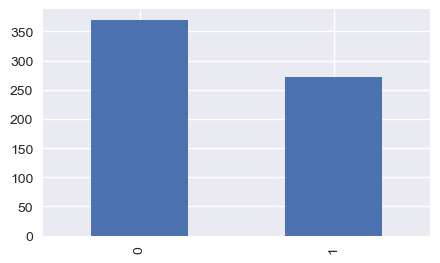

In [140]:
plt.style.use('seaborn')
plt.figure(figsize=(5,3), dpi=100)
data['label'].value_counts().plot(kind='bar')

In [141]:
data['content'] = data['content'].str.lower()
data.head()

,content,label
0,@ricardo70078700 i have a big problem buying f...,0
1,rt @tconnellyrte : 6/ “one colleague working o...,0
2,rt @joncstone : in case you missed this from m...,0
3,rt @alexandravonnah : eu climate chief: 'we ne...,0
4,rt @fourens__ : my colleague just told me she ...,0


In [142]:
data['content'] = data['content'].apply(lambda string: ' '.join([word for word in string.split(' ') if not word.rstrip(' ').startswith('@')]))
data['content'] = data['content'].apply(lambda string: ' '.join([word for word in string.split(' ') if not word.rstrip(' ').startswith('#')]))
data['content'] = data['content'].apply(lambda string: ' '.join([word for word in string.split(' ') if not word.rstrip(' ').startswith('http')]))

data.head()

,content,label
0,i have a big problem buying from all the metho...,0
1,rt : 6/ “one colleague working on ni was nearl...,0
2,rt : in case you missed this from my colleague,0
3,rt : eu climate chief: 'we need to be more amb...,0
4,rt : my colleague just told me she bought a ho...,0


In [143]:
stop_words = set(stopwords.words('english'))
stop_words.add('rt')

In [144]:
def text_process(text):
    tokenizer = RegexpTokenizer('[a-z0-9]+')
    token = tokenizer.tokenize(text)
    lemmatizer = WordNetLemmatizer()
    token = [lemmatizer.lemmatize(w) for w in token if lemmatizer.lemmatize(w) not in stop_words]
    return token

In [145]:
data['content'] = data['content'].apply(text_process)

In [146]:
data

,content,label
0,"[big, problem, buying, method, country, accept...",0
1,"[6, one, colleague, working, ni, wa, nearly, t...",0
2,"[case, missed, colleague]",0
3,"[eu, climate, chief, need, ambitious, frans, t...",0
4,"[colleague, told, bought, house, wa, gifted, 3...",0
...,...,...
637,"[bos, dog, married, dog, covered, dog, food, y...",0
638,"[neighbor, bos, friendly, people, community]",0
639,"[looking, forward, department, dinner, friday]",0
640,"[bos, shameless]",1


In [147]:
X = data['content']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 71)

In [148]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [149]:
train

,content,label
545,"[hearing, dog, training, pluto, brilliant, job...",0
356,"[ex, workmate, like, may, chika, ako, maritess...",1
570,"[dim, fuck, government, level, want, long, mon...",1
36,"[done, bos, download, add, download, link, boo...",0
385,"[youngkin, trump, toady, conspiracy, theorist,...",1
...,...,...
296,"[several, hour, game, none, team, india, membe...",1
552,"[great, job, give, away, pension, foreign, aid...",1
55,"[spare, nvme, trouble, shooting, see, get, wor...",0
11,"[following, myth, thread, last, week, much, em...",0


0    296
1    217
Name: label, dtype: int64


<AxesSubplot:>

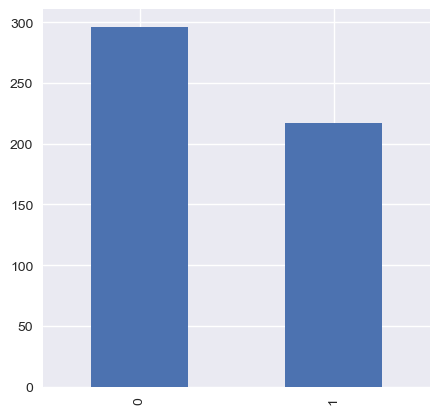

In [150]:
print(train['label'].value_counts())
plt.figure(figsize=(5,5), dpi=100)
train['label'].value_counts().plot(kind='bar')

0    74
1    55
Name: label, dtype: int64


<AxesSubplot:>

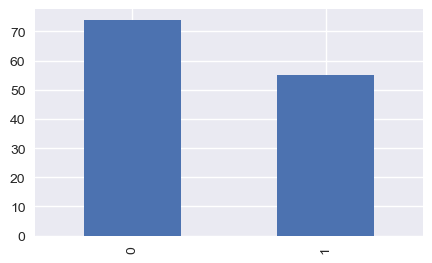

In [151]:
print(test['label'].value_counts())
plt.figure(figsize=(5,3), dpi=100)
test['label'].value_counts().plot(kind='bar')

In [152]:
non_sensitive_train = train[train['label'] == 0]
sensitive_train = train[train['label'] == 1]

In [153]:
non_sensitive_train

,content,label
545,"[hearing, dog, training, pluto, brilliant, job...",0
36,"[done, bos, download, add, download, link, boo...",0
582,"[ever, considered, teamwork, also, spell, work...",0
172,"[tla, ha, created, new, resource, partnership,...",0
124,"[government, job]",0
...,...,...
33,"[flexed, bos, finishing, back, work, office, p...",0
223,"[really, wanted, fix, reputation, misconduct, ...",0
55,"[spare, nvme, trouble, shooting, see, get, wor...",0
11,"[following, myth, thread, last, week, much, em...",0


In [154]:
# non_sensitive_train_part = non_sensitive_train['content'].sample(139, random_state=42)
# sensitive_train_part = sensitive_train['content'].sample(139, random_state=42)

non_sensitive_trainset = non_sensitive_train['content']
sensitive_trainset = sensitive_train['content']

vocablist = []
for i in pd.concat([non_sensitive_trainset, sensitive_trainset]):
    vocablist += i

In [155]:
vocablist

['hearing',
 'dog',
 'training',
 'pluto',
 'brilliant',
 'job',
 'shopping',
 'trip',
 'pluto',
 'started',
 'training',
 'public',
 'place',
 'like',
 'shop',
 'restaurant',
 'couple',
 'month',
 'ago',
 'taking',
 'new',
 'environment',
 'stride',
 'well',
 'done',
 'pluto',
 'done',
 'bos',
 'download',
 'add',
 'download',
 'link',
 'bookmark',
 'device',
 'check',
 'respond',
 'ever',
 'considered',
 'teamwork',
 'also',
 'spell',
 'workmate',
 'simple',
 'thing',
 'true',
 'teamwork',
 'tla',
 'ha',
 'created',
 'new',
 'resource',
 'partnership',
 'w',
 'colleague',
 'help',
 'build',
 'support',
 'ed',
 'wellbeing',
 'combat',
 'burnout',
 'amp',
 'potential',
 'resignation',
 'support',
 'student',
 'government',
 'job',
 'goal',
 'gender',
 'equality',
 'gender',
 'harmony',
 '16',
 'yr',
 'good',
 'governance',
 'corruption',
 'employing',
 'family',
 'member',
 'staying',
 'apartment',
 'demanding',
 'higher',
 'salary',
 'job',
 'angela',
 'merkel',
 'respect',
 'happy',


In [156]:
trainset_texts = [' '.join(content) for content in np.concatenate((non_sensitive_trainset.values, sensitive_trainset.values))]

train_all_texts = [' '.join(content) for content in train['content']]

test_all_texts = [' '. join(content) for content in test['content']]


In [157]:
trainset_texts

['hearing dog training pluto brilliant job shopping trip pluto started training public place like shop restaurant couple month ago taking new environment stride well done pluto',
 'done bos download add download link bookmark device check respond',
 'ever considered teamwork also spell workmate simple thing true teamwork',
 'tla ha created new resource partnership w colleague help build support ed wellbeing combat burnout amp potential resignation support student',
 'government job',
 'goal gender equality gender harmony',
 '16 yr good governance corruption employing family member staying apartment demanding higher salary job angela merkel respect happy retirement',
 'vejamos caso tal z trov carinha dele hoje n aparece na galeria da interpol n fa ideia motivo ineg vel que hoje interpol n aprovou inclus e se negarem pode ficar feio para stf e brasil http co yuraxqg51w',
 'colleague told bought house wa gifted 30k grandma kind wealth trying sew kid grandkids life',
 'new survey data sugg

In [158]:
cv = CountVectorizer()
trainset_fit = cv.fit(trainset_texts)
train_all_count = cv.transform(train_all_texts)
test_all_count = cv.transform(test_all_texts)

In [159]:
train_all_count

<513x3488 sparse matrix of type '<class 'numpy.int64'>'
	with 7695 stored elements in Compressed Sparse Row format>

In [160]:
tfidf = TfidfTransformer()
train_tfidf_matrix = tfidf.fit_transform(train_all_count)
test_tfidf_matrix = tfidf.fit_transform(test_all_count)

In [161]:
train_tfidf_matrix

<513x3488 sparse matrix of type '<class 'numpy.float64'>'
	with 7695 stored elements in Compressed Sparse Row format>

In [162]:
model = MultinomialNB(alpha=1.1, fit_prior=True, class_prior=None).fit(train_tfidf_matrix, y_train)

In [163]:
model.score(test_tfidf_matrix, y_test)

0.7906976744186046

In [164]:
pred = model.predict(test_tfidf_matrix)
acc = 1 - np.sum(np.abs(y_test - pred)) / len(y_test)
print(acc)

0.7906976744186046


In [165]:
from sklearn import datasets,linear_model,svm

def test_LinearSVC(*data):
    x_train,x_test,y_train,y_test=data
    cls=svm.LinearSVC()
    cls.fit(x_train,y_train)
    print('SVM')
    print('Coefficients:%s, intercept %s'%(cls.coef_,cls.intercept_))
    print('Score: %.2f' % cls.score(x_test, y_test))


test_LinearSVC(train_tfidf_matrix,test_tfidf_matrix,y_train,y_test)   

SVM
Coefficients:[[ 0.46218809  0.36314499  0.03374835 ...  0.07848062  0.21126076
  -0.1962498 ]], intercept [-0.28461451]
Score: 0.78


In [166]:
def test_SVC_Linear(*data):
    x_train,x_test,y_train,y_test=data
    cls=svm.SVC(kernel='linear')
    cls.fit(x_train,y_train)
    print('non-linear SVM')
    # print('Coefficients:%s, intercept %s'%(cls.coef_,cls.intercept_))
    print('Score: %.2f' % cls.score(x_test, y_test))

test_SVC_Linear(train_tfidf_matrix,test_tfidf_matrix,y_train,y_test)

non-linear SVM
Score: 0.78


In [167]:
from sklearn.neighbors import KNeighborsClassifier
#KNN, neuighbors=10
knn = KNeighborsClassifier(n_neighbors=10)

knn.fit(train_tfidf_matrix, y_train)
knn.score(test_tfidf_matrix, y_test)

0.6976744186046512

In [168]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import time

NBM = [SVC(kernel='linear', C=0.5), 
       SVC(kernel='rbf', C=0.5, gamma='auto'),
       SVC(kernel='poly', C=0.5, degree=3), 
       KNeighborsClassifier(n_neighbors=11), 
       MultinomialNB(),
       DecisionTreeClassifier(max_depth=15, min_samples_split=5), #防止过拟合将树深设为10
       AdaBoostClassifier(DecisionTreeClassifier(max_depth=15, min_samples_split=5),
                                                 n_estimators=200, learning_rate=0.8),#选择决策树，迭代000次，学习率为0.8
       RandomForestClassifier(n_estimators= 200, max_depth=10)]
NAME= ["LINEAR","RBF","poly", "KNN_N11", "MNB","DCT", "Boosting_Ada", "Bagging_RF"]
for itr, itrname in zip(NBM, NAME):
    #训练过程
    print("Training...")
    t1 = time.perf_counter()
    itr.fit(train_tfidf_matrix, y_train)
    t2 = time.perf_counter()
    print("Applying...")
    y_train_pdt = itr.predict(train_tfidf_matrix)
    t3 = time.perf_counter()
    y_test_pdt = itr.predict(test_tfidf_matrix)

    dts1 = len(np.where(y_train_pdt==y_train)[0])/len(y_train)
    dts2 = len(np.where(y_test_pdt==y_test)[0])/len(y_test)
    
    acc1 = accuracy_score(y_train_pdt, y_train)
    acc2 = accuracy_score(y_test_pdt, y_test)
    
    pre1 = precision_score(y_train_pdt, y_train)
    pre2 = precision_score(y_test_pdt, y_test)
    
    rec1 = recall_score(y_train_pdt, y_train)
    rec2 = recall_score(y_test_pdt, y_test)

    print("model_train：{} accuracy:{:.3f}%, precision:{:.3f}%, recall:{:.3f}%, time：{:.2f}s".format(itrname, acc1*100, pre1*100, rec1*100, t2 - t1))
    print("model_test：{} accuracy:{:.3f}%, precision:{:.3f}%, recall:{:.3f}%, time：{:.2f}s".format(itrname, acc2*100, pre2*100, rec2*100, t3 - t2))
    

Training...
Applying...
model_train：LINEAR accuracy:84.990%, precision:64.977%, recall:99.296%, time：0.05s
model_test：LINEAR accuracy:79.845%, precision:52.727%, recall:100.000%, time：0.04s
Training...
Applying...
model_train：RBF accuracy:57.700%, precision:0.000%, recall:0.000%, time：0.03s
model_test：RBF accuracy:57.364%, precision:0.000%, recall:0.000%, time：0.03s
Training...


/Users/yhl125/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yhl125/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Applying...
model_train：poly accuracy:59.649%, precision:4.608%, recall:100.000%, time：0.04s
model_test：poly accuracy:57.364%, precision:0.000%, recall:0.000%, time：0.04s
Training...
Applying...
model_train：KNN_N11 accuracy:74.464%, precision:46.083%, recall:87.719%, time：0.00s
model_test：KNN_N11 accuracy:74.419%, precision:50.909%, recall:82.353%, time：0.02s
Training...
Applying...
model_train：MNB accuracy:99.025%, precision:98.157%, recall:99.533%, time：0.00s
model_test：MNB accuracy:78.295%, precision:54.545%, recall:90.909%, time：0.00s
Training...
Applying...
model_train：DCT accuracy:89.864%, precision:76.037%, recall:100.000%, time：0.01s
model_test：DCT accuracy:70.543%, precision:56.364%, recall:68.889%, time：0.00s
Training...
Applying...
model_train：Boosting_Ada accuracy:100.000%, precision:100.000%, recall:100.000%, time：2.73s
model_test：Boosting_Ada accuracy:69.767%, precision:76.364%, recall:61.765%, time：0.06s
Training...
Applying...
model_train：Bagging_RF accuracy:76.998%, pr

In [64]:
clf = MultinomialNB(alpha=1, fit_prior=True, class_prior=None).fit(train_tfidf_matrix, y_train)
clf.score(test_tfidf_matrix, y_test)

0.77

In [40]:
#text = "@Alice My name is Bob, I work in Microsoft. #highqualityman https:bscn3789de.com"
#text = "Today is my Birthday."
#text = "My salary is $2000 per month"
#text = "My boss Roan is a foolish man"
#text = "I hope Alice get fired tommorrow"
#text = "My workmate is nice"
#text = "My workmate is bad"
#text = "My workmate is shameless"
#text = "My employee John is good"
#text = "My employee John is good but stupid"
#text = "My employee John is stupid, but he pays me a lot"



df = pd.DataFrame({"text":text},index=["0"])

df['text'] = df['text'].str.lower()
df['text'] = df['text'].apply(lambda string: ' '.join([word for word in string.split(' ') if not word.rstrip(' ').startswith('@')]))
df['text'] = df['text'].apply(lambda string: ' '.join([word for word in string.split(' ') if not word.rstrip(' ').startswith('#')]))
df['text'] = df['text'].apply(lambda string: ' '.join([word for word in string.split(' ') if not word.rstrip(' ').startswith('http')]))
df['text'] = df['text'].apply(text_process)
print(df['text'])


0    [employee, john, good, stupid]
Name: text, dtype: object


In [47]:
print(df['text'])
text_content = [' '.join(content) for content in df['text']]
print(text_content)
print('---')

text_count = cv.transform(text_content)
print(text_count)
print('+++')
text_tfidf_matrix = tfidf.fit_transform(text_count)
pre = clf.predict(text_tfidf_matrix)
print(pre)


0    [employee, john, good, stupid]
Name: text, dtype: object
['employee john good stupid']
---
  (0, 855)	1
  (0, 1116)	1
  (0, 2490)	1
+++
[1]


In [37]:
doc = nlp(text)
print(*[f'entity: {ent.text}\ttype: {ent.type}' for sent in doc.sentences for ent in sent.ents], sep='\n')
for ent in doc.ents:
    if ent.type == 'PERSON':
        print("You may leak 'name' information.")
    if ent.type == 'MONEY':
        print("You may leak 'money' information.")

entity: 2000	type: MONEY
You may leak 'money' information.
